## Probability maps animation

This notebook creates an animation showing the evolution of the predicted time-dependent deposit probability from 170Ma-present. The notebook `02-create_probability_maps.ipynb` must have been run previously.

In [1]:
use_extracted_data = True


In [2]:
import glob
import os
import tempfile

import cartopy.crs as ccrs
import pandas as pd
import pygplates
from gplately import (
    PlateReconstruction,
    PlotTopologies,
)
from joblib import Parallel, delayed
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

from lib.check_files import (
    check_plate_model,
    check_prepared_data,
)
from lib.visualisation import plot

# Suppress occasional joblib warnings
%env PYTHONWARNINGS=ignore::UserWarning

NOTEBOOK = "get_ipython" in dir()


env: PYTHONWARNINGS=ignore::UserWarning


In [3]:
n_jobs = int(os.environ.get("N_JOBS", 8))
verbose = True
projection = ccrs.Orthographic(-100, 10)

output_dir = os.path.join("outputs", "Americas")


### Load plate model files

In [4]:
model_dir = "plate_model"
check_plate_model(model_dir, verbose=True)
feature_filenames = glob.glob(
    os.path.join(
        model_dir,
        r"*.gpml",
    )
)
rotation_filenames = glob.glob(
    os.path.join(
        model_dir,
        r"*.rot",
    )
)
coastlines_filename = os.path.join(
    model_dir,
    "StaticGeometries",
    "AgeGridInput",
    "CombinedTerranes.gpml",
)

reconstruction = PlateReconstruction(
    rotation_model=rotation_filenames,
    topology_features=pygplates.FeatureCollection(
        [
            i for i in pygplates.FeaturesFunctionArgument(
                feature_filenames
            ).get_features()
            if i.get_feature_type().to_qualified_string()
            != "gpml:TopologicalSlabBoundary"
        ]
        
    ),
)
gplot = PlotTopologies(
    plate_reconstruction=reconstruction,
    coastlines=coastlines_filename,
)


### Load training data

In [5]:
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = "prepared_data"
    check_prepared_data(data_dir, verbose=True)
training_filename = os.path.join(data_dir, "training_data.csv")
training_data = pd.read_csv(training_filename)
positives = training_data[training_data["label"] == "positive"]


### Example plot

if 1 == 2:
    gplot
    
    def plot_subduction_teeth(
        geometries,
        width,
        polarity=None,
        height=None,
        spacing=None,
        projection="auto",
        transform=None,
        ax=None,
        **kwargs,
    ):
    
    
    TEETH_KWARGS = {
        "size": 8,
        "aspect": 0.7,
        "spacing": 0.15,
        "markerfacecolor": "black",
        "markeredgecolor": "black",
        "zorder": TOPOLOGIES_KWARGS["zorder"],
    }
    SCATTER_KWARGS = {
        "linestyle": "none",
        "marker": "*",
        "markersize": 15,
        "markerfacecolor": "red",
        "markeredgecolor": "black",
        "markeredgewidth": 0.6,
        "transform": ccrs.PlateCarree(),
        "zorder": TEETH_KWARGS["zorder"] + 1,
    }    
    
     gplot.plot_subduction_teeth(ax=ax, **TEETH_KWARGS)
    


PU example plot:


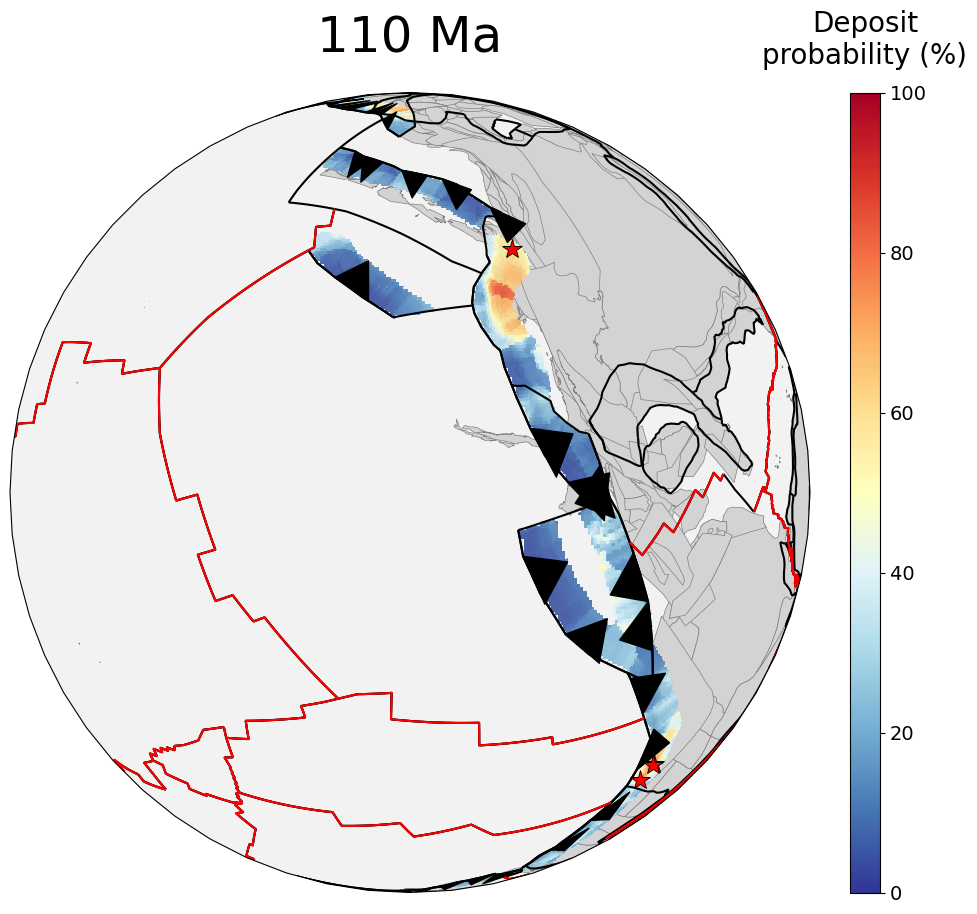

In [6]:
# Example plot (only in notebook)
if NOTEBOOK:
    t_example = 110  # Ma
    gplot.time = t_example
    algorithm = "PU"
    probs_dir = os.path.join(output_dir, algorithm, "probability_grids")

    print(f"{algorithm} example plot:")
    fig = plot(
        gplot=gplot,
        probabilities=os.path.join(
            probs_dir,
            f"probability_grid_{t_example:0.0f}Ma.nc",
        ),
        positives=positives,
        projection=projection,
        time=t_example,
        central_meridian=-100,
    )


### Create all plots

In [7]:
times = range(171)
gplot_kw = dict(
    rotation_model=rotation_filenames,
    topology_features=feature_filenames,
    coastlines=coastlines_filename,
)

for algorithm in ("PU", "SVM"):
    output_filename = os.path.join(
        output_dir,
        algorithm,
        "probability_animation.mp4",
    )
    probs_dir = os.path.join(output_dir, algorithm, "probability_grids")

    # Create all plots
    with tempfile.TemporaryDirectory() as tmpdir, \
            Parallel(n_jobs=n_jobs, verbose=int(verbose)) as parallel:
        output_filenames = [
            os.path.join(tmpdir, f"image_{t:0.0f}Ma.png")
            for t in times
        ]
        parallel(
            delayed(plot)(
                gplot=gplot_kw,
                probabilities=os.path.join(
                    probs_dir,
                    f"probability_grid_{t:0.0f}Ma.nc",
                ),
                projection=projection,
                time=t,
                positives=positives[
                    (positives["age (Ma)"] - float(t)).abs()
                    <= 2.5
                ],
                output_filename=o,
                central_meridian=-100,
            )
            for t, o in zip(times, output_filenames)
        )

        with ImageSequenceClip(output_filenames[::-1], fps=5) as clip:
            clip.write_videofile(
                output_filename,
                fps=30,
                codec="mpeg4",
                bitrate="5000k",
                audio=False,
                threads=n_jobs,
                logger="bar" if verbose else None,
                ffmpeg_params=[
                    "-vf",
                    "pad=ceil(iw/2)*2:ceil(ih/2)*2",
                ],
            )


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   43.0s
[Parallel(n_jobs=8)]: Done 171 out of 171 | elapsed:  3.1min finished


Moviepy - Building video outputs/Americas/PU/probability_animation.mp4.
Moviepy - Writing video outputs/Americas/PU/probability_animation.mp4



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.                                                                                                                                        


Moviepy - Done !
Moviepy - video ready outputs/Americas/PU/probability_animation.mp4


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   41.7s
[Parallel(n_jobs=8)]: Done 171 out of 171 | elapsed:  3.0min finished


Moviepy - Building video outputs/Americas/SVM/probability_animation.mp4.
Moviepy - Writing video outputs/Americas/SVM/probability_animation.mp4



Moviepy - Done !
Moviepy - video ready outputs/Americas/SVM/probability_animation.mp4
